# About run_sequence_clustering_analysis

This notebook clusters action sequences and analyzes the resulting clusters

In [1]:
%load_ext autoreload
%autoreload 1
%aimport utils_timeline_viz
%aimport utils_read_parsing
%aimport generalized_seq_miner
from utils_timeline_viz import *
from utils_read_parsing import *
from generalized_seq_miner import *
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 12,4
from matplotlib.backends.backend_pdf import PdfPages
import os
import numpy as np
import pandas as pd
import getpass
import datetime
import json
import matplotlib
import matplotlib.pyplot as plt
from itertools import groupby
from tabulate import tabulate
pd.set_option('display.max_columns', None);pd.set_option('display.max_rows', None);pd.set_option('precision', 2)
# FOLDER =  'C:\\Users\\'+getpass.getuser()+'\\Documents\\Personal Content\\Lab_skills_study\\parsed log data'

# Loading data

We grab the student learning data

In [2]:
df_all = get_df_all_factors(all_vars=True)
variables = list(set(df_all['variable']))
ids = list(set(df_all['sid']))
N = len(ids)
print 'We have',N,'students.'
print 'Running the analaysis on the following variables:',', '.join(variables)

We have 147 students.
Running the analaysis on the following variables: Battery voltage, Area, Width, Separation, Wavelength, Concentration


We grab the sequences

In [3]:
import pickle
from utils_sequence_parsing import Sequence
pickle_in_seqs = open(os.path.join(BIG_FOLDER,'all_massaged_data\\dict_by_sim_by_student_parsed_seqs.txt'),"r")
all_seqs = pickle.load(pickle_in_seqs)
pickle_in_seqs.close()

## Tranform sequences

We transform the sequences by blocking certain actions, removing others, merging some and generalizing
We store all seqs as a list of Sequence() items

In [4]:
transformed_seqs = []
for sim,seqs_by_student in all_seqs.iteritems():
    for sid,seq in seqs_by_student.iteritems():
        seq.remove_actions('ignore')
        seq.remove_actions('V_ruler')
        seq.merge_actions(['P','P_notes'])
        seq.block_actions(['P','V_area', 'V_battery', 'V_lightbulb', 'V_separation','V_other','V_width','V_concentration','V_wavelength','V_detector','V_laser'])
        seq.block_actions(['G_add','G_add_fail','G_remove','T_remove'])
        seq.translate_variable_actions()
        seq.check_lengths_seq_timecoords()
        transformed_seqs.append(seq)

In [5]:
print len(transformed_seqs)

294


In [6]:
transformed_seqs[0].parameters()

Length:127 actions, sid:23836160, sim:beers, blocked actions:set(['V_separation', 'V_wavelength', 'V_detector', 'V_other', 'V_lightbulb', 'G_add_fail', 'G_add', 'T_remove', 'G_remove', 'P', 'V_width', 'V_area', 'V_concentration', 'V_laser', 'V_battery']),actions removed: set(['ignore', 'V_ruler']), merged_actions: set([('P', 'P_notes')]), has timecoords: True


# Clustering
## Distance matrix

In [7]:
def lcs(X, Y): 
    # find the length of the strings 
    m = len(X) 
    n = len(Y) 
  
    # declaring the array for storing the dp values 
    L = [[None]*(n + 1) for i in xrange(m + 1)] 
  
    """Following steps build L[m + 1][n + 1] in bottom up fashion 
    Note: L[i][j] contains length of LCS of X[0..i-1] 
    and Y[0..j-1]"""
    for i in range(m + 1): 
        for j in range(n + 1): 
            if i == 0 or j == 0 : 
                L[i][j] = 0
            elif X[i-1] == Y[j-1]: 
                L[i][j] = L[i-1][j-1]+1
            else: 
                L[i][j] = max(L[i-1][j], L[i][j-1]) 
  
    # L[m][n] contains the length of LCS of X[0..n-1] & Y[0..m-1] 
    return L[m][n] 
# end of function lcs 

We define a matrix that will store all our sequences distances

In [8]:
M = len(transformed_seqs)
lcs_scores = np.zeros((M,M))
normalized = np.zeros((M,M))

In [9]:
%timeit
for i,s1 in enumerate(transformed_seqs):
    for j,s2 in enumerate(transformed_seqs):
        score = lcs(s1.seq,s2.seq)
        if i==j:
            lcs_scores[i][j] = 0
        else:
            lcs_scores[i][j] = score
        normalized[i][j] = len(s1.seq)+ len(s2.seq) - 2*score # the greater distance, the greater the score

In [10]:
lcs_scores

array([[ 0., 38., 44., ..., 71., 64., 58.],
       [38.,  0., 45., ..., 40., 36., 37.],
       [44., 45.,  0., ..., 58., 50., 45.],
       ...,
       [71., 40., 58., ...,  0., 65., 76.],
       [64., 36., 50., ..., 65.,  0., 54.],
       [58., 37., 45., ..., 76., 54.,  0.]])

In [11]:
np.mean(lcs_scores),max(lcs_scores.flatten()),min(lcs_scores.flatten())

(35.868249340552545, 105.0, 0.0)

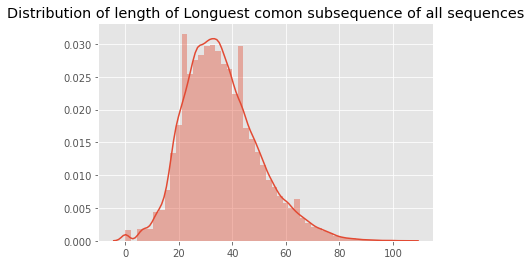

In [12]:
sns.distplot(lcs_scores.flatten())
plt.title('Distribution of length of Longuest comon subsequence of all sequences');

Text(0.5,1,'Distribution of length of Longuest comon subsequence of all sequences')

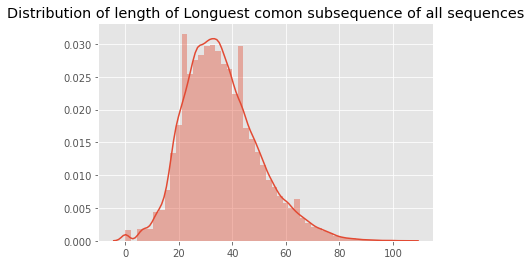

In [13]:
sns.distplot(lcs_scores.flatten())
plt.title('Distribution of length of Longuest comon subsequence of all sequences')

Text(0.5,1,'Distribution of normalized length of Longuest comon subsequence of all sequences')

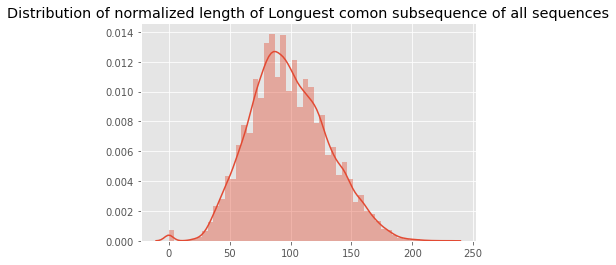

In [14]:
sns.distplot(normalized.flatten())
plt.title('Distribution of normalized length of Longuest comon subsequence of all sequences')

## Hierarchical clustering

In [15]:
# import scipy.spatial.distance as ssd
# # convert the redundant n*n square matrix form into a condensed nC2 array
# distArray = ssd.squareform(normalized)

We choose Agglomerative Clustering because it works with large samples, large number of clusters and any pair-wise distance

from https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering:

"Hierarchical clustering is a general family of clustering algorithms that build nested clusters by merging or splitting them 
successively. This hierarchy of clusters is represented as a tree (or dendrogram). The root of the tree is the unique cluster that gathers all the samples, the leaves being the clusters with only one sample. See the Wikipedia page for more details"

Need to pick a linkage method (what merges samples into clusters). Ward gives the most regular sizes. However, the affinity (or distance used in clustering) cannot be varied with Ward, thus for non Euclidean metrics, average linkage is a good alternative.

In [16]:
from sklearn.cluster import AgglomerativeClustering

## Run clustering with different number of clusters

In [18]:
range_n_clusters = [2,3,4,5,6,7,8,9,10]
clustering_byN = {}
for n_clusters in range_n_clusters:
    clustering_byN[n_clusters] = AgglomerativeClustering(linkage='single', affinity='precomputed', n_clusters=n_clusters, compute_full_tree = True).fit(normalized)

Silhouette analysis

('For n_clusters =', 2, 'The average silhouette_score is :', 0.5726378771266223)
2 293
2 1
('For n_clusters =', 3, 'The average silhouette_score is :', 0.5119652502322756)
3 292
3 1
3 1
('For n_clusters =', 4, 'The average silhouette_score is :', 0.5082740743327193)
4 291
4 1
4 1
4 1
('For n_clusters =', 5, 'The average silhouette_score is :', 0.4036926972012598)
5 290
5 1
5 1
5 1
5 1
('For n_clusters =', 6, 'The average silhouette_score is :', 0.40789566211342293)
6 289
6 1
6 1
6 1
6 1
6 1
('For n_clusters =', 7, 'The average silhouette_score is :', 0.3959002347317616)
7 288
7 1
7 1
7 1
7 1
7 1
7 1
('For n_clusters =', 8, 'The average silhouette_score is :', 0.40122956269421606)
8 287
8 1
8 1
8 1
8 1
8 1
8 1
8 1
('For n_clusters =', 9, 'The average silhouette_score is :', 0.3679368171020604)
9 286
9 1
9 1
9 1
9 1
9 1
9 1
9 1
9 1
('For n_clusters =', 10, 'The average silhouette_score is :', 0.3077267199063785)
10 285
10 1
10 1
10 1
10 1
10 1
10 1
10 1
10 1
10 1


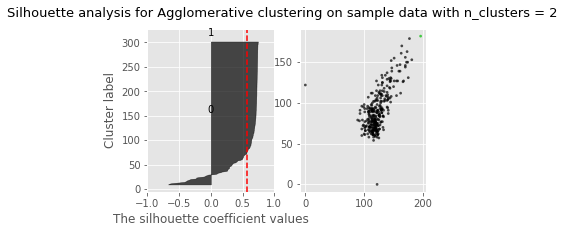

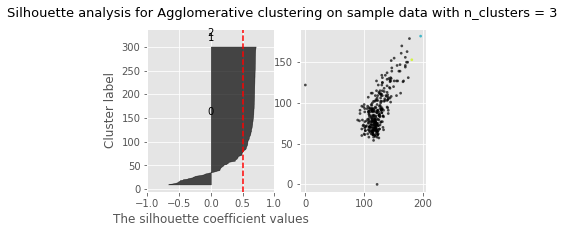

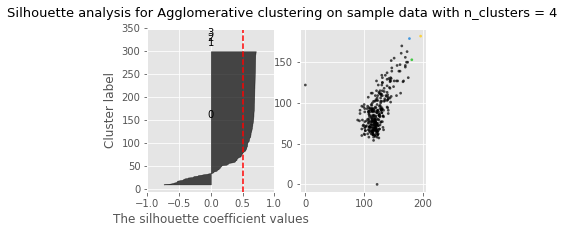

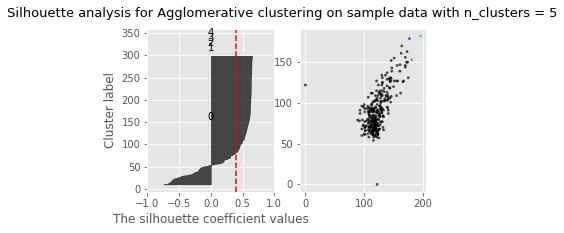

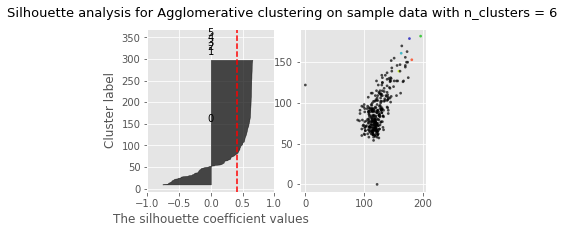

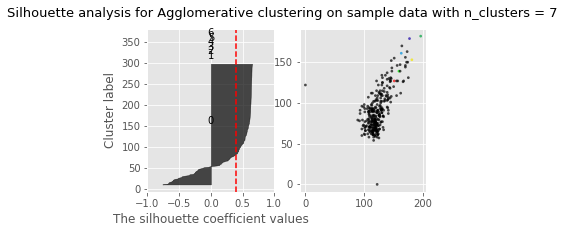

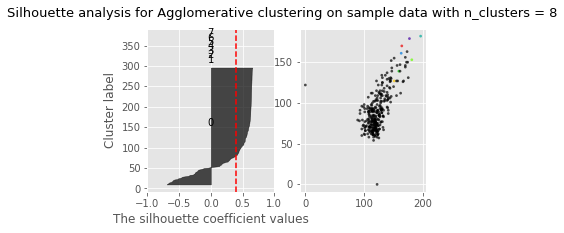

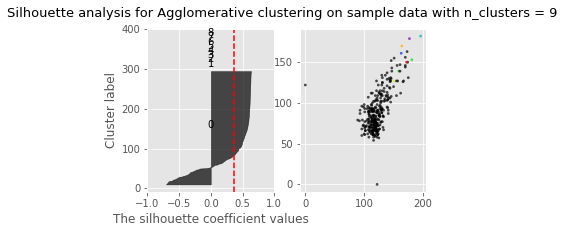

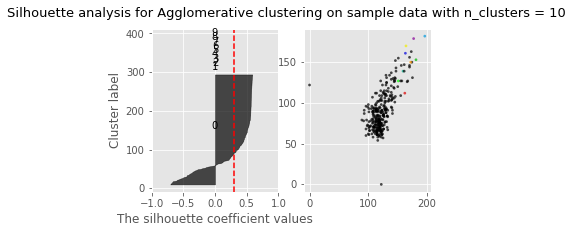

In [20]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(5,3)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    #here our silhouette scores dont go above 0.5
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
#     ax1.set_ylim([0, len(X) + (n_clusters + 1) * 1])

    cluster_labels = clustering_byN[n_clusters].labels_

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(normalized, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(normalized, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        print n_clusters,size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

#     ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

#     ax1.set_yticks([])  # Clear the yaxis labels / ticks
#     ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(normalized[:, 0], normalized[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

#     ax2.set_title("The visualization of the clustered data.")
    plt.suptitle(("Silhouette analysis for Agglomerative clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=13)

plt.show()

Complete clustering failure :)

## Run clustering with a distance threshold
We pick a distance such that sequence pairs with a greater distance than this thresold can't be in the same cluster.
We pick thresholds such that it encompasses 10,20,30,40% of sequence pairs

In [21]:
# import sklearn
# sklearn.__version__

'0.20.3'

In [22]:
# clustering_by_dt = {}
# for p in [10,20,30,40]:
#     t = np.percentile(normalized,p)
#     print p,t
#     clustering_by_dt[t] = AgglomerativeClustering(linkage='average', affinity='precomputed', n_clusters=None, distance_threshold = t, compute_full_tree = True).fit(normalized)
#     print clustering_by_dt

10 59.0


TypeError: __init__() got an unexpected keyword argument 'distance_threshold'

## Visualizing results

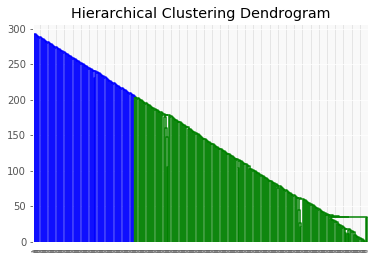

In [24]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(clustering_byN[2], labels=clustering_byN[2].labels_)
plt.show()

# Todo

1. Pick a way to measure similarity/distance between sequences
    * Longest common subsequence
    * Number of subsequences in comon (lots of features)
* Cluster
    * Pick clustering algorithm to run on distance matrix
    * update sklearn so we can run with distance threshold
    * Visualize with tree
    * Pick number of clusters (using silhouette or cross validation analysis)
* Random forests
    * make data point * feature matrix
    * do CVS with different sized trees
* Analyze!